In [15]:
import numpy as np
import random
import scipy
from scipy import sparse
import theano
import pandas as pd
import theano.tensor as T
import matplotlib.pyplot as plt

In [2]:
# data = pd.read_csv('/Users/chenkeyi/Downloads/mnist_train_100.csv')
# data.head()
# type(data)

# #get the training data
# data = pd.DataFrame.as_matrix(data)
# y = data[:,0]
# A = data[:,1:]

In [6]:
def svrg(grad, init_step_size, n, d, max_epoch=100, m=0, x0=None, func=None,
            verbose=True):
    """
        SVRG for solving finite-sum problems
        grad: gradient function in the form of grad(x, idx), where idx is a list of induces
        init_step_size: initial step size
        n, d: size of the problem
        func: the full function, f(x) returning the function value at x
    """
    if not isinstance(m, int) or m <= 0:
        m = n
        if verbose:
            print('Info: set m=n by default')

    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')
        

    step_size = init_step_size   
    func_value = []
    for k in range(max_epoch):
        full_grad = grad(x, range(n))
        x_tilde = x.copy()
        if verbose:
            
            output = 'Epoch.: %d, Step size: %.2e, Grad. norm: %.2e' % \
                     (k, step_size, np.linalg.norm(full_grad))
            if func is not None:
                output += ', Func. value: %e' % func(x)
        
        for i in range(m):
            idx = (random.randrange(n), )
            x -= step_size * (grad(x, idx) - grad(x_tilde, idx) + full_grad)
            func_value.append(func(x))
    return x, func_value




In [7]:
def sgd(grad, init_step_size, n, d, max_epoch=300, x0=None, 
           func=None, verbose=True):
    """
        grad: gradient function in the form of grad(x, idx), where idx is a list of induces
        init_step_size: initial step size
        n, d: size of the problem
        func: the full function, f(x) returning the function value at x
    """
    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')

        
    step_size = init_step_size
    func_value = [] 
    for i in range(max_epoch):
        if verbose:
            full_grad = grad(x, range(n))
            output = 'Epoch.: %d, Step size: %.2e, Grad. norm: %.2e' % \
                     (i, step_size, np.linalg.norm(full_grad))
            if func is not None:                
                output += ', Func. value: %e' % func(x) 
            
        idx = (random.randrange(n), )
        g = grad(x, idx)
        x -= step_size * g
        func_value.append(func(x))
            



    return x, func_value 



In [8]:

if __name__ == '__main__':
    
     # problem size
    n, d = 1000, 100

    # randomly generate training data
    A = np.random.randn(n, d)
    x_true = np.random.randn(d)
    y = np.sign(np.dot(A, x_true) + 0.1 * np.random.randn(n))

    # generate test data
    A_test = np.random.randn(n, d)
    y_test = np.sign(np.dot(A_test, x_true))


    # preprocess data
    tmp = scipy.sparse.lil_matrix((n, n))
    tmp.setdiag(y)
    data = theano.shared(tmp * A)
    # define objective function and gradient via Theano
    l2 = 1e-3
    par = T.vector()
    
    loss = T.log(1 + T.exp(-T.dot(data, par))).mean() + l2 / 2 * (par ** 2).sum()
    func = theano.function(inputs=[par], outputs=loss)

    idx = T.ivector()    
    grad = theano.function(inputs=[par, idx],outputs= T.grad(loss,par),givens={data: data[idx, :]})



In [6]:
# # test SVRG
# x0 = np.random.rand(d)
# print('Begin to run SVRG-BB:')
# x = svrg(grad, 1e-3, n, d, func=func, max_epoch=50)
# y_predict = np.sign(np.dot(A_test, x))
# print('Test accuracy: %f' % (np.count_nonzero(y_test == y_predict)*1.0 / n))

In [7]:
# # test SGD
# print('\nBegin to run SGD-BB:')    
# x = sgd(grad, 1e-3, n, d, func=func, max_epoch=50)
# y_predict = np.sign(np.dot(A_test, x))
# print('Test accuracy: %f' % (np.count_nonzero(y_test == y_predict)*1.0 / n))

In [11]:
# SGD 
print('\nBegin to run SGD:') 
sgd_result = sgd(grad, 0.05, n, d, func=func, max_epoch=1000) 
x = sgd_result[0] 
f_value = sgd_result[1]

y_predict = np.sign(np.dot(A_test, x))
print('Test accuracy: %f' % (np.count_nonzero(y_test == y_predict)*1.0 / n))


Begin to run SGD-BB:
Test accuracy: 0.876000


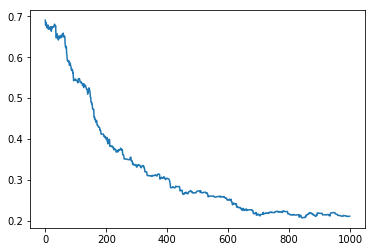

In [12]:
plt.title('SGD with learning rate 0.05')
plt.plot(f_value)

In [13]:
# Svrg
x0 = np.random.rand(d)
print('Begin to run SVRG-BB:')
svrg_result = svrg(grad, 0.05, n, d, func=func, max_epoch=50)

x = svrg_result[0]
f2_value = svrg_result[1]

y_predict = np.sign(np.dot(A_test, x))
print('Test accuracy: %f' % (np.count_nonzero(y_test == y_predict)*1.0 / n))

Begin to run SVRG-BB:
Info: set m=n by default
Test accuracy: 0.957000


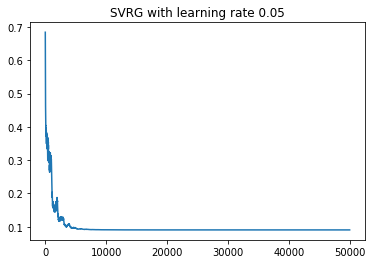

In [14]:
plt.title('SVRG with learning rate 0.05')
plt.plot(f2_value)